![alt text](https://live.staticflickr.com/4544/38228876666_3782386ca7_b.jpg)

## Paso 1: Descarga del Dataset

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./cats_and_dogs_filtered.zip

--2020-04-20 13:36:10--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M   148MB/s    in 0.4s    

2020-04-20 13:36:11 (148 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



# Pre-Procesado de datos

## Importar librerias


In [2]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import style

from tqdm import tqdm_notebook

tf.__version__

'2.2.0-rc3'

## Descomprimir Dataset

In [0]:
dataset_path = './cats_and_dogs_filtered.zip'
zip_obj = zipfile.ZipFile(dataset_path , mode='r')

In [0]:
zip_obj.extractall(path='./' )

In [0]:
zip_obj.close()

## Configurar rutas del dataset

In [0]:
path_dir = './cats_and_dogs_filtered'
train_dir = os.path.join(path_dir , 'train')
validation_dir = os.path.join(path_dir , 'validation')

# Contruir Modelo

## Cargar un modelo pre entrenador (MobileNet V2)
* Es un modelo un poco mas pequenio que el original
* Es un modelo convucional asi que va a esperar valores fijos

In [0]:
IMG_SHAPE = (128 , 128 , 3)

In [8]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE , include_top=False , weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [9]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

## Congelar modelo base

In [0]:
base_model.trainable = False
# de esta forma se congela completamente todo el modelo

## Definir la cabecera personalizada para nuestra red neuronal

In [11]:
base_model.output
## esta es la salida del modelo
## como podemos observar, devuelve un objeto 4x4 de 1280 de profundidad

<tf.Tensor 'out_relu/Identity:0' shape=(None, 4, 4, 1280) dtype=float32>

In [0]:
## esta es una tecnica de pooling
### consiste en promediar los valores y generar una salida
# el (base_model) se utiliza para especificar la entrada
global_avange_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

In [13]:
global_avange_layer

<tf.Tensor 'global_average_pooling2d/Identity:0' shape=(None, 1280) dtype=float32>

In [0]:
predict_layer = tf.keras.layers.Dense(units=1 , activation='sigmoid')(global_avange_layer)

## Definir Modelo
* Con anterioridad estabamos definiendo una secuencia, pero ahora definiremos Models.
* El model nos va a permitir convinar redes neuonales

In [0]:
model = tf.keras.Model(inputs=base_model.input , outputs=predict_layer)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________________

Si analizamos el `summary()` anterior podemos ver que tenemos `Non-trainable params`, ya que lo hemos congelado. 
## Compilar el modelo
* RMS : es el mejor para clasificacion binarios

In [0]:
opt = tf.keras.optimizers.RMSprop(lr=0.0001)
# Estoy especificando un valor pequenio a 0 porque ya esta entrenada la red.

model.compile(optimizer=opt, loss='binary_crossentropy' , metrics=['accuracy'])

## Crear generadores de datos
Vamos a preprocesar los datos.
Cuando habalmos de modelos pre-entrenados estos ya tienen una configuracion de antemano que aceptan.

Este modelo soporta: (96,96) , (128,128) , (160,160) , (192,192) , (224,224)

`ImageDataGenerator`: Nos permite entrenar un modelo a traves de lotes (es una forma que nos va a permitir disminuir la carga al procesador)
* Ademas posee `data argumentation`, que nos permite escalar y modificar una imagen a traves de diferentes formatos
  * Esto nos va a permitir aumentar el tamanio de nuestro dataset

In [18]:
# Con este formato no funciona
'''
data_gen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
data_gen_test = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
train_generator = data_gen_train.flow_from_directory(train_dir, target_size=(128,128), class_mode='binary')
test_generator = data_gen_test.flow_from_directory(validation_dir , target_size=(128,128), class_mode='binary')
print(type(train_generator))
print(train_generator)
'''

"\ndata_gen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)\ndata_gen_test = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)\ntrain_generator = data_gen_train.flow_from_directory(train_dir, target_size=(128,128), class_mode='binary')\ntest_generator = data_gen_test.flow_from_directory(validation_dir , target_size=(128,128), class_mode='binary')\nprint(type(train_generator))\nprint(train_generator)\n"

### Ejemplo y analisis de datos

In [0]:
## abrir imagen y guardar
from PIL import Image

JPEG
(300, 280)
RGB


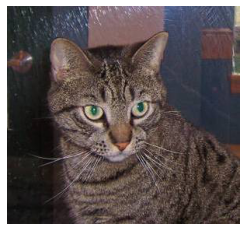

(280, 300, 3)

In [20]:
## ejemplo para trabajarlo
tmp = os.path.join(train_dir,'cats','cat.1.jpg') #abrir
img = Image.open(tmp)
print(img.format)
print(img.size)
print(img.mode)

plt.imshow(img)
plt.axis('off')
plt.show()

data = np.asarray(img) #convertir a array
data.shape

### Extraccion de datos

In [0]:
x_train = []
y_train = []
x_test = []
y_test = []

#save train data
for a in ['cat' , 'dog']:
  clas = a + 's'
  for i in range(1000):
    image_dir = a + '.' + str(i) + '.jpg'
    temp = os.path.join(train_dir, clas ,image_dir)
    img = Image.open(temp)
    img = img.resize((128,128))
    x_train.append(np.asarray(img))
    if a == 'cat':
      y_train.append(0)
    else:
      y_train.append(1)

#save test data
for a in ['cat','dog']:
  clas = a + 's'
  for i in range(500):
    image_dir = a + '.' + str(2000 + i) + '.jpg'
    temp = os.path.join( validation_dir, clas , image_dir)
    img = Image.open(temp)
    img = img.resize((128,128))
    x_test.append(np.asarray(img))
    if a == 'cat':
      y_test.append(0)
    else:
      y_test.append(1)

### Conversion de datos
#### Todo a tipo Array

In [0]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [43]:
print(x_train.shape)
print(x_train[0].shape)
print(x_test.shape)
print(x_test[0].shape)

(2000, 128, 128, 3)
(128, 128, 3)
(1000, 128, 128, 3)
(128, 128, 3)


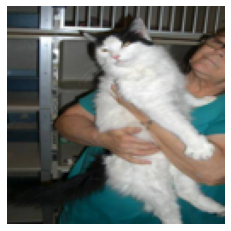

In [44]:
plt.imshow(x_train[25])
plt.axis('off')
plt.show()

#### Todo a un formato Homogeneo

In [45]:
x_train = x_train / 255.
x_test = x_test / 255.
print(x_train[0])

[[[0.8        0.64705882 0.34509804]
  [0.81960784 0.66666667 0.36470588]
  [0.82352941 0.67058824 0.37254902]
  ...
  [0.96862745 0.81176471 0.49411765]
  [0.96078431 0.8        0.4745098 ]
  [0.94117647 0.78823529 0.47843137]]

 [[0.8        0.64705882 0.34509804]
  [0.81960784 0.66666667 0.36470588]
  [0.82352941 0.67058824 0.37254902]
  ...
  [0.96862745 0.81960784 0.50196078]
  [0.96078431 0.80392157 0.48235294]
  [0.94901961 0.79215686 0.48235294]]

 [[0.8        0.64705882 0.34509804]
  [0.81960784 0.66666667 0.36470588]
  [0.82352941 0.67058824 0.37254902]
  ...
  [0.96862745 0.82352941 0.50980392]
  [0.96078431 0.81176471 0.49411765]
  [0.95294118 0.8        0.48627451]]

 ...

 [[0.61960784 0.48627451 0.21176471]
  [0.62352941 0.49411765 0.21568627]
  [0.62745098 0.49803922 0.21960784]
  ...
  [0.01176471 0.01568627 0.        ]
  [0.01176471 0.01568627 0.        ]
  [0.00784314 0.00784314 0.        ]]

 [[0.60784314 0.48627451 0.21960784]
  [0.61176471 0.49019608 0.22352941]


# Entrenar Modelo
Considerando que son 2000 datos de entradas y por lotes de 128, la cantidad de veces que deberia de ejecutarse deberian de ser 16. Sin embargo el tipo de dato no debe andar funcionando

In [48]:
model.fit(x=x_train , y=y_train , epochs=5, batch_size=128)

Epoch 1/5
16/16 [==============================] - 20s 1s/step - loss: 0.3678 - accuracy: 0.8595
Epoch 2/5
16/16 [==============================] - 19s 1s/step - loss: 0.3320 - accuracy: 0.8815
Epoch 3/5
16/16 [==============================] - 19s 1s/step - loss: 0.3019 - accuracy: 0.8905
Epoch 4/5
16/16 [==============================] - 20s 1s/step - loss: 0.2769 - accuracy: 0.9015
Epoch 5/5
16/16 [==============================] - 19s 1s/step - loss: 0.2571 - accuracy: 0.9110


In [49]:
loss_test , accuracy_test = model.evaluate(x=x_test , y=y_test)

32/32 [==============================] - 10s 326ms/step - loss: 0.2394 - accuracy: 0.9140


## Puesta a punto de parámetros
  Ajustar los parametros de un modelo preentrenado.
  
Un par de cosas:

- NUNCA HAY QUE USAR la puesta a punto (fine tuning) de parámetros en toda la red neuronal: con algunas de las capas superiores (las finales) es más que suficiente suficiente. En la mayoría de casos, son las más especializadas. El objetivo del fine tuning es adaptar esa parte específica de la red neuronal para nuestro nuevo dataset específico.
- Empezar con la puesta a punto DESPUÉS de haber finalizado la fase de aprendizaje por transferencia. Si intentamos hacer el Fine tuning inmediatamente, los gradientes serán muy diferentes entre nuestra cabecera personalizada de la red neuronal y las nuevas capas no congeladas del modelo base.

### Descongelar unas cuantas capas superiores del modelo

In [0]:
base_model.trainable = True

In [51]:
print('Number of layers in the base model: {}'.format(len(base_model.layers)))

Number of layers in the base model: 155


In [0]:
fine_tune = 100

In [0]:
for layer in base_model.layers[:fine_tune]:
  layer.trainable = False

Desde la capa 0 hasta la 100 estan congeladas y las ultimas 50 capas estan lista para entrenarse

### Compilar el modelo para la puesta a punto

In [0]:
model.compile(optimizer=opt , loss='binary_crossentropy' , metrics=['accuracy'])

### Puesta a punto

In [56]:
model.fit(x=x_train , y=y_train , epochs=5 , batch_size=128)

Epoch 1/5
16/16 [==============================] - 40s 3s/step - loss: 0.1840 - accuracy: 0.9260
Epoch 2/5
16/16 [==============================] - 40s 3s/step - loss: 0.0273 - accuracy: 0.9980
Epoch 3/5
16/16 [==============================] - 40s 3s/step - loss: 0.0116 - accuracy: 0.9995
Epoch 4/5
16/16 [==============================] - 40s 3s/step - loss: 0.0046 - accuracy: 1.0000
Epoch 5/5
16/16 [==============================] - 40s 3s/step - loss: 0.0020 - accuracy: 1.0000


### Evaluar el modelo re calibrado

In [57]:
loss_test , accuracy_test = model.evaluate(x=x_test , y=y_test)

32/32 [==============================] - 10s 327ms/step - loss: 0.1875 - accuracy: 0.9510


In [58]:
print("Validation accuracy after fine tuning: {}".format(accuracy_test))

Validation accuracy after fine tuning: 0.9509999752044678
